# Analysis for Figure3

In [7]:
1

1

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import scanpy.external as sce
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import rapids_singlecell as rsc
import scanpy as sc
import cupyx as cpx
import pandas as pd
import numpy as np
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scib
import scib_metrics

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
tardis.config = tardis.config_server

sc.settings.verbosity = 3

print(f"CUDA used: {torch.cuda.is_available()}")

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/xla.py:18: DeprecationWarning: `ModuleAvailableCache` is a special case of `RequirementCache`. Please use `RequirementCache(module=...)` instead.
  from lightning.fabric.accelerators.tpu import _XLA_AVAILABLE, TPUAccelerator
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning.fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_na

CUDA used: True


In [5]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_GSM_new.h5ad")
    assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
    adata = ad.read_h5ad(adata_file_path)
    adata.X = adata.layers["counts"].copy()
    del adata.layers
    adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
    adata.obs["dose_val_log"] = np.log10(adata.obs["dose_val"] + 1e-6)
    gc.collect()

In [454]:
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
display(d)

{0.0: 0, 0.1: 1, 0.5: 2, 1.0: 3, 5.0: 4, 10.0: 5, 50.0: 6, 100.0: 7}

In [455]:
adata.obs.value_counts(["dose_training", "dose", "dose_val"])

dose_training  dose   dose_val
3              1.0    0.010       2171
0              0.0    0.000       2155
1              0.1    0.001       1961
5              10.0   0.100       1940
2              0.5    0.005       1792
4              5.0    0.050       1790
6              50.0   0.500       1767
7              100.0  1.000       1235
dtype: int64

In [385]:
np.unique(np.round(adata.obs["dose_val_log"]))

array([-6., -3., -2., -1., -0.])

In [386]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    "sciplex-cpa_age_dose-continuous"
)
vae = tardis.MyModel.load(dir_path, adata=adata)

INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/sciplex-cpa_age_dose-continuous/model.pt    
         already downloaded                                                                                        


In [387]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


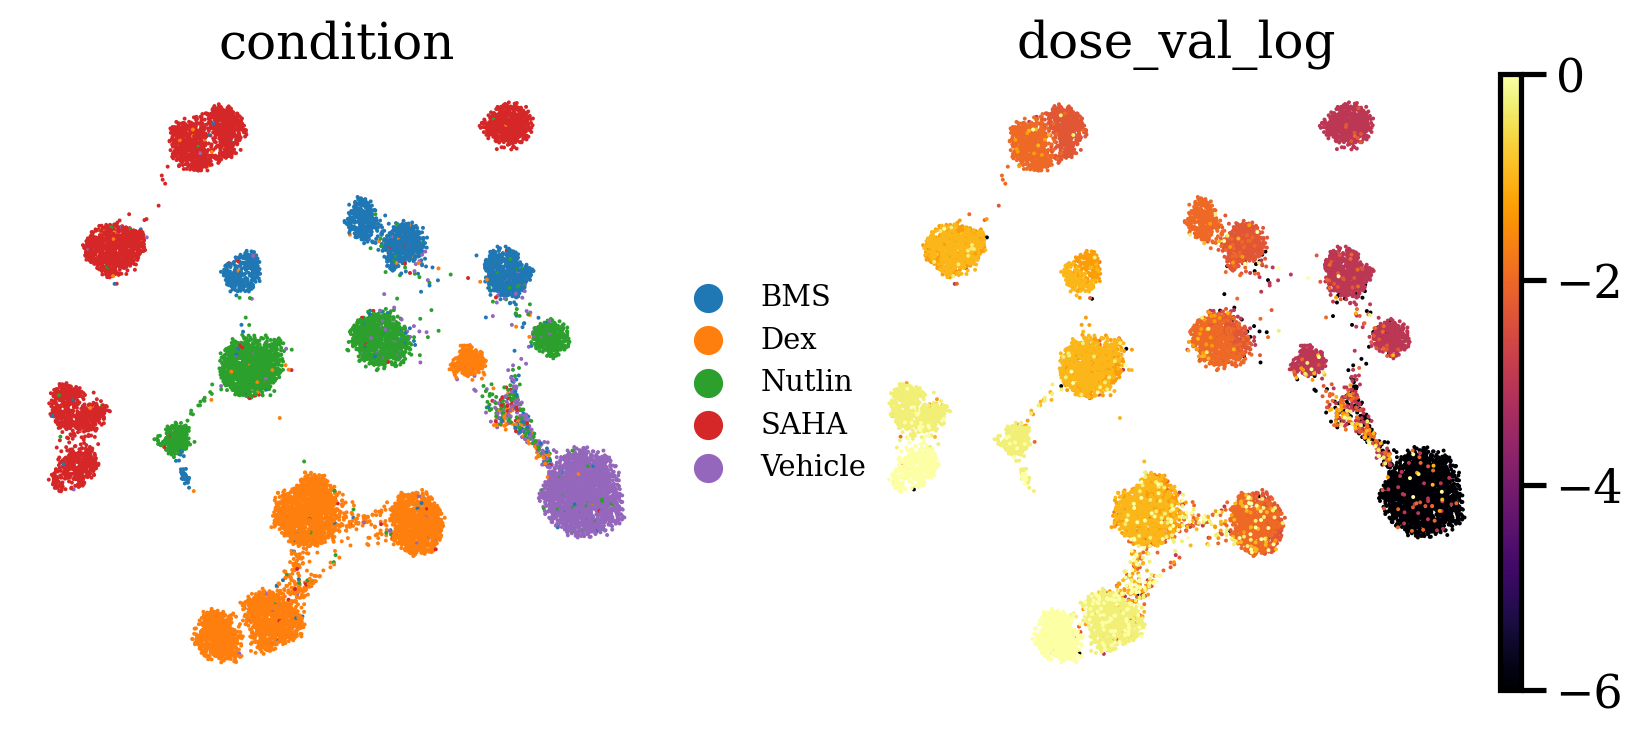

In [388]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent,
        color=["condition", "dose_val_log"],
        ncols=2,
        color_map="inferno",
        frameon=False,
        legend_fontsize="xx-small",
        show=False,
    )
    plt.show()
    # del latent
    # gc.collect()

In [391]:
from tardis._disentanglementmanager import DisentanglementManager

In [392]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DisentanglementManager.configurations.get_by_obs_key("dose_val_log").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


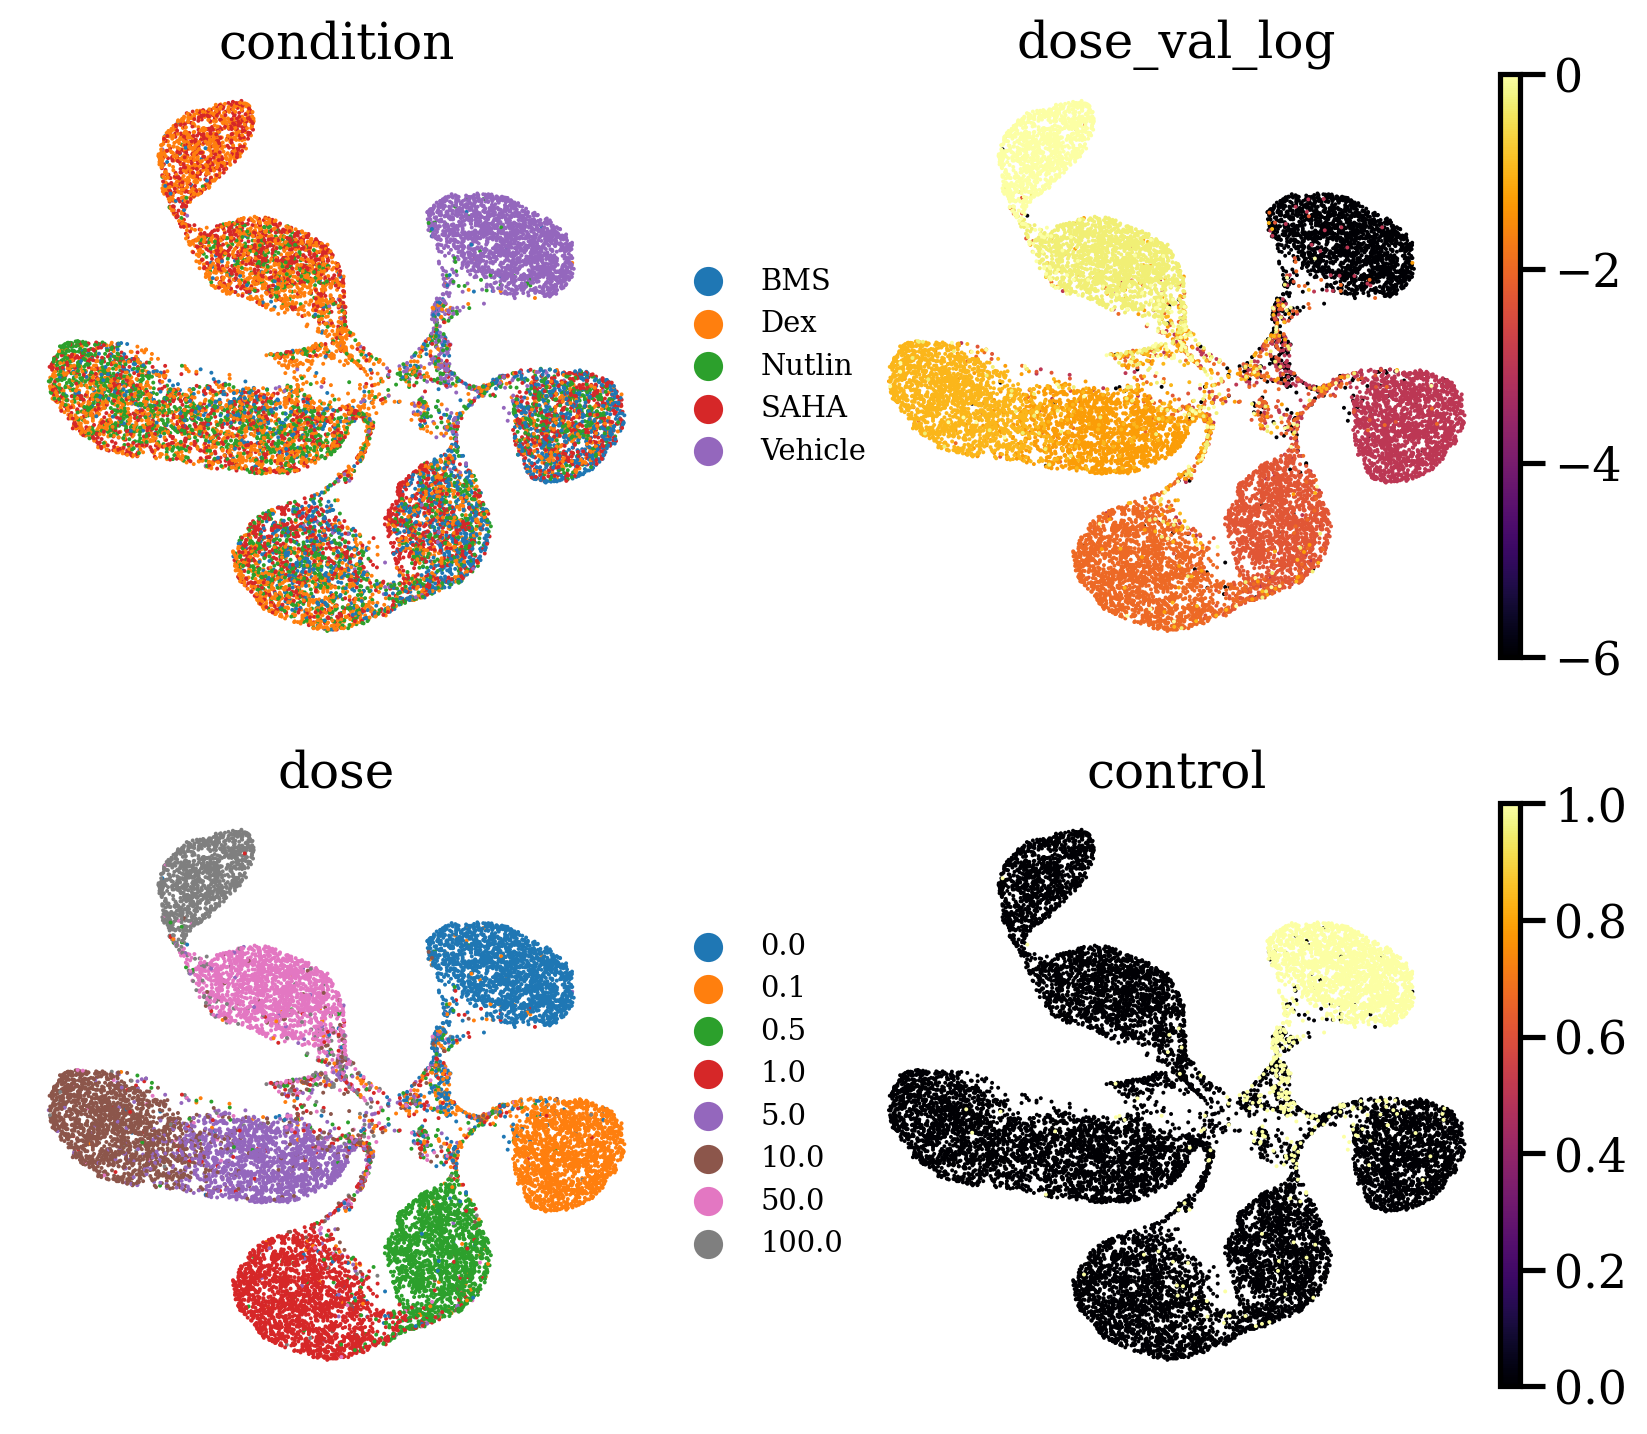

In [393]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent,
        color=["condition", "dose_val_log", "dose", "control"],
        ncols=2,
        color_map="inferno",
        frameon=False,
        legend_fontsize="xx-small",
        show=False,
    )
    plt.show()
    # del latent
    # gc.collect()

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


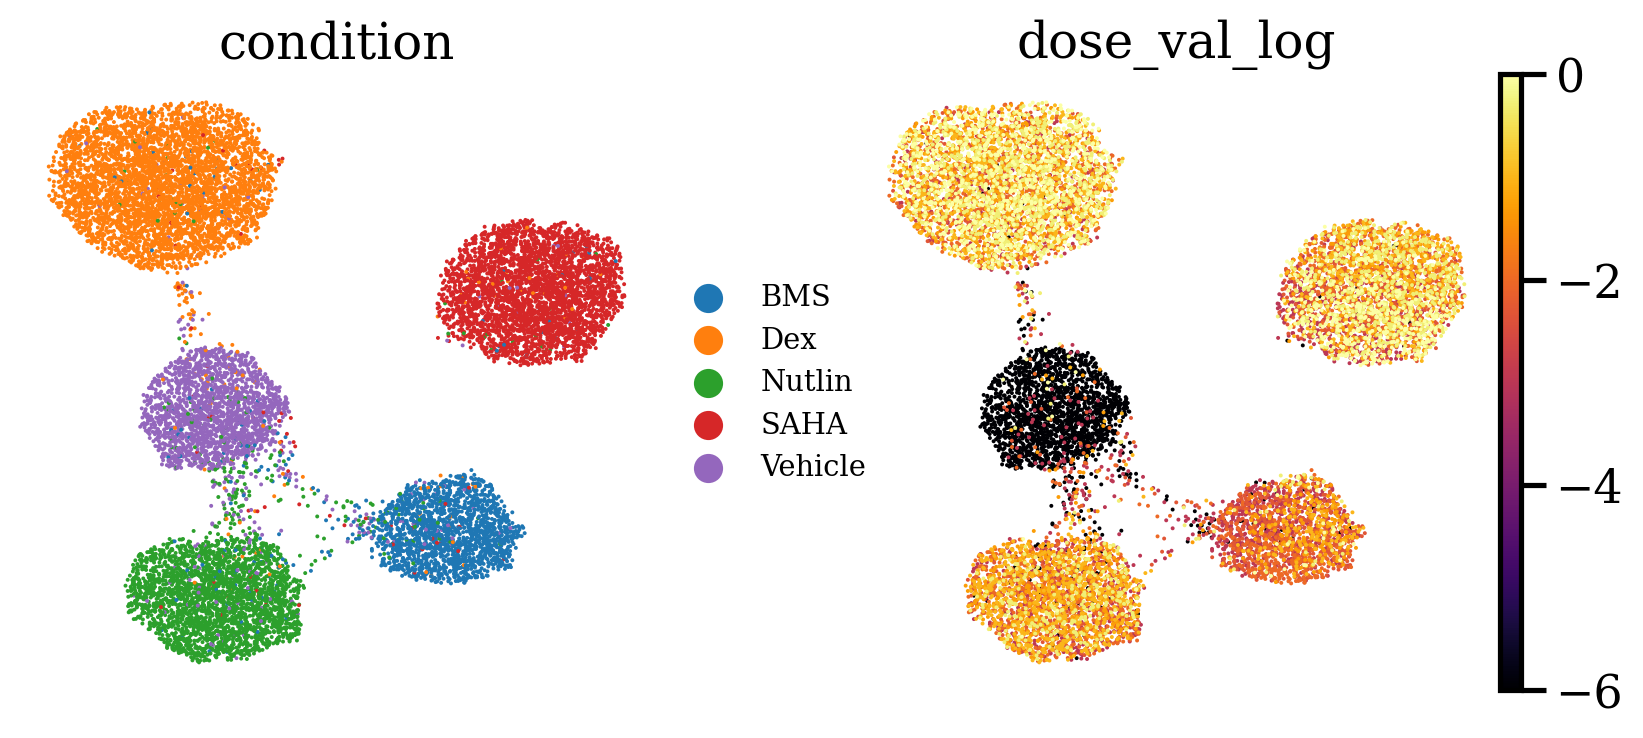

In [394]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DisentanglementManager.configurations.get_by_obs_key("condition").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent,
        color=["condition", "dose_val_log"],
        ncols=2,
        color_map="inferno",
        frameon=False,
        legend_fontsize="xx-small",
        show=False,
    )
    plt.show()
    # del latent
    # gc.collect()

In [395]:
batch_size_vae_metrics = 512

vae_metrics = {
    "reconstruction_error": vae.get_reconstruction_error(batch_size=batch_size_vae_metrics)['reconstruction_loss'],
    "elbo": vae.get_elbo(batch_size=batch_size_vae_metrics).item(),
    "r2_train": vae.get_reconstruction_r2(batch_size=batch_size_vae_metrics, indices=vae.train_indices),
    "r2_validation": vae.get_reconstruction_r2(batch_size=batch_size_vae_metrics, indices=vae.validation_indices),
}
for k, v in vae_metrics.items():
    print(k, v)

reconstruction_error -1884.5603183444737
elbo -1945.0137939453125
r2_train 0.9979492900338149
r2_validation 0.9964339832736039


In [396]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DisentanglementManager.configurations.get_by_obs_key("dose_val_log").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 50)
sc.tl.umap(latent)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


In [397]:
sc.tl.diffmap(latent, n_comps=50)

computing Diffusion Maps using n_comps=50(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9996958  0.99960995 0.9994136  0.99921227 0.99839
     0.9970256  0.99590975 0.99031883 0.98597115 0.98457974 0.98372054
     0.9815408  0.9802204  0.979241   0.9791175  0.97688663 0.9756887
     0.9738081  0.9713223  0.9694948  0.96729106 0.9655518  0.96507657
     0.9638839  0.9619746  0.9606277  0.95977145 0.95825595 0.9562326
     0.95586884 0.9548922  0.9537166  0.9522074  0.94860315 0.94660336
     0.9445357  0.94109684 0.9402294  0.93782586 0.9357785  0.9337289
     0.9336602  0.932423   0.9311814  0.93088794 0.928633   0.9272966
     0.92690504 0.9264465 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:01)


In [398]:
stem_mask = np.isin(latent.obs["dose_val"], latent.obs["dose_val"].min())
# opt_stem_id = np.argmin(latent.obsm["X_diffmap"][stem_mask, 10])
# root_id = np.arange(len(stem_mask))[stem_mask][opt_stem_id]
latent.uns["iroot"] = np.where(stem_mask)[0][2]

In [399]:
sc.tl.dpt(latent)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


In [400]:
latent

AnnData object with n_obs × n_vars = 14811 × 8
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_val_log', '_scvi_batch', '_scvi_labels', 'dpt_pseudotime'
    uns: 'neighbors', 'umap', 'diffmap_evals', 'iroot'
    obsm: 'X_umap', 'X_diffmap'
    obsp: 'distances', 'connectivities'

In [401]:
latent.obs["c"] = (latent.obs["dose"] == "100.0").astype(str)

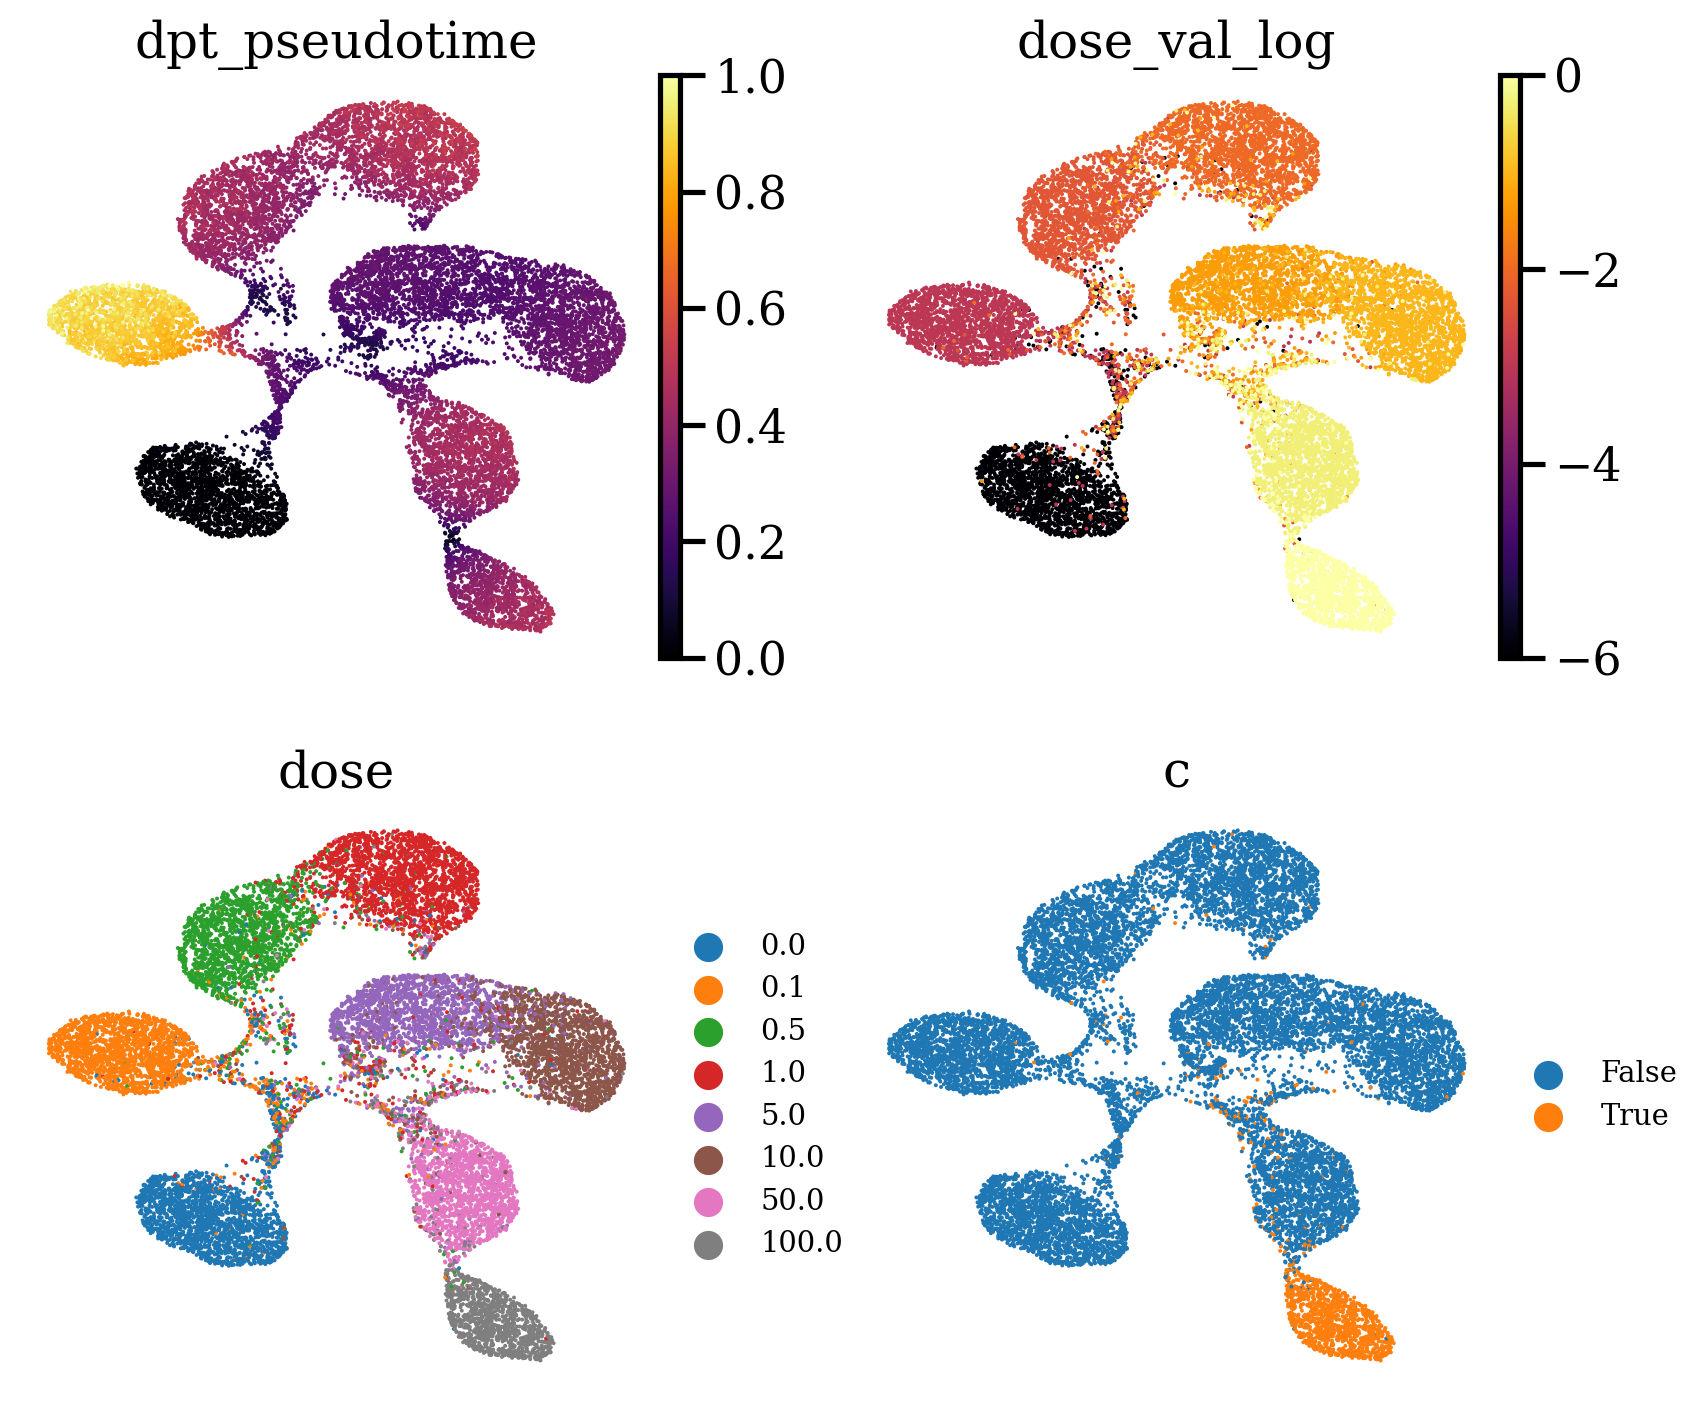

In [402]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent,
        color=["dpt_pseudotime", "dose_val_log", "dose", "c"],
        ncols=2,
        color_map="inferno",
        frameon=False,
        legend_fontsize="xx-small",
        show=False,
    )
    plt.show()

In [403]:
def paga(adata, groups="louvain"):
    """ """

    sc.pp.neighbors(adata)
    sc.tl.paga(adata, groups=groups)
    _ = sc.pl.paga_compare(adata, show=False)

    fig1, ax1 = plt.subplots()
    sc.pl.umap(adata, size=10, ax=ax1, show=False)
    sc.pl.paga(
        adata,
        pos=adata.uns["paga"]["pos"],
        show=False,
        node_size_scale=10,
        node_size_power=1,
        ax=ax1,
        text_kwds={"alpha": 0.5},
    )
    plt.show()


computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


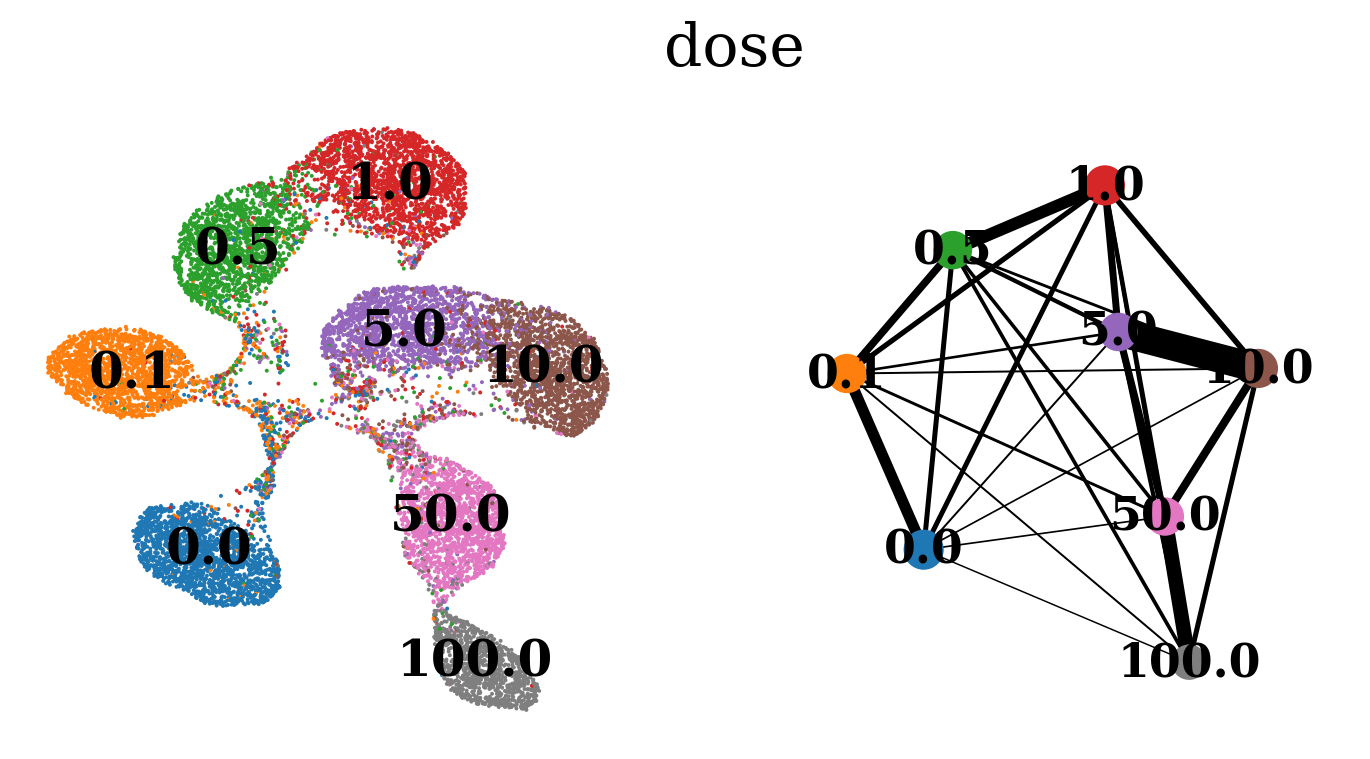

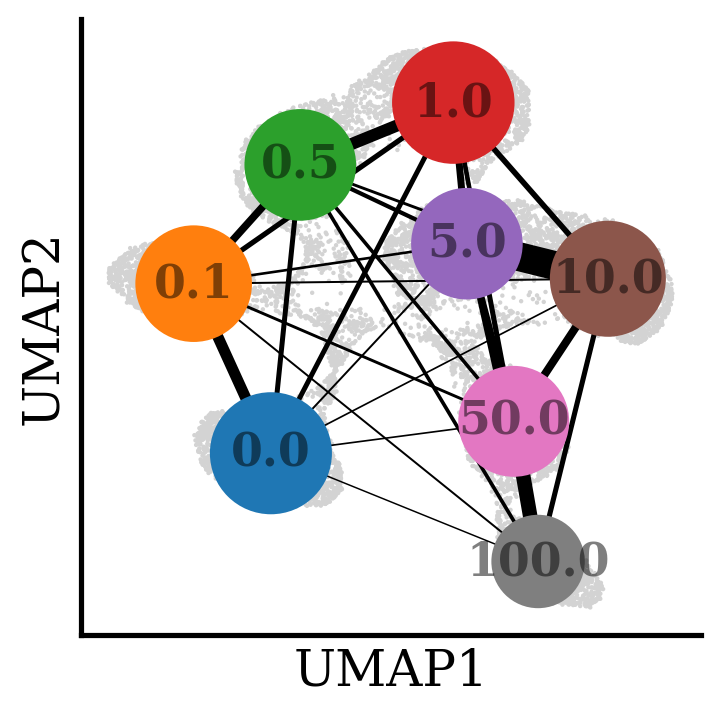

In [404]:
paga(latent, groups="dose")

In [405]:
latent

AnnData object with n_obs × n_vars = 14811 × 8
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_val_log', '_scvi_batch', '_scvi_labels', 'dpt_pseudotime', 'c'
    uns: 'neighbors', 'umap', 'diffmap_evals', 'iroot', 'dose_colors', 'c_colors', 'paga', 'dose_sizes'
    obsm: 'X_umap', 'X_diffmap'
    obsp: 'distances', 'connectivities'

--> added 'pos', the PAGA positions (adata.uns['paga'])


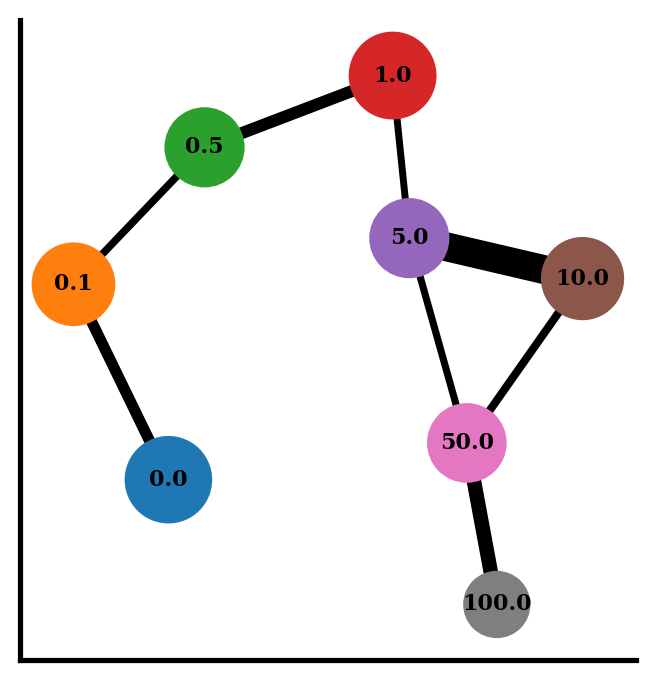

In [406]:
sc.pl.paga(
    latent,
    threshold=0.221,
    pos=latent.uns["paga"]["pos"],
    show=False,
    node_size_scale=5,
    node_size_power=1,
    text_kwds={"alpha": 1},
    fontsize=8,

)
plt.show()

In [407]:
latent

AnnData object with n_obs × n_vars = 14811 × 8
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_val_log', '_scvi_batch', '_scvi_labels', 'dpt_pseudotime', 'c'
    uns: 'neighbors', 'umap', 'diffmap_evals', 'iroot', 'dose_colors', 'c_colors', 'paga', 'dose_sizes'
    obsm: 'X_umap', 'X_diffmap'
    obsp: 'distances', 'connectivities'

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


--> added 'pos', the PAGA positions (adata.uns['paga'])


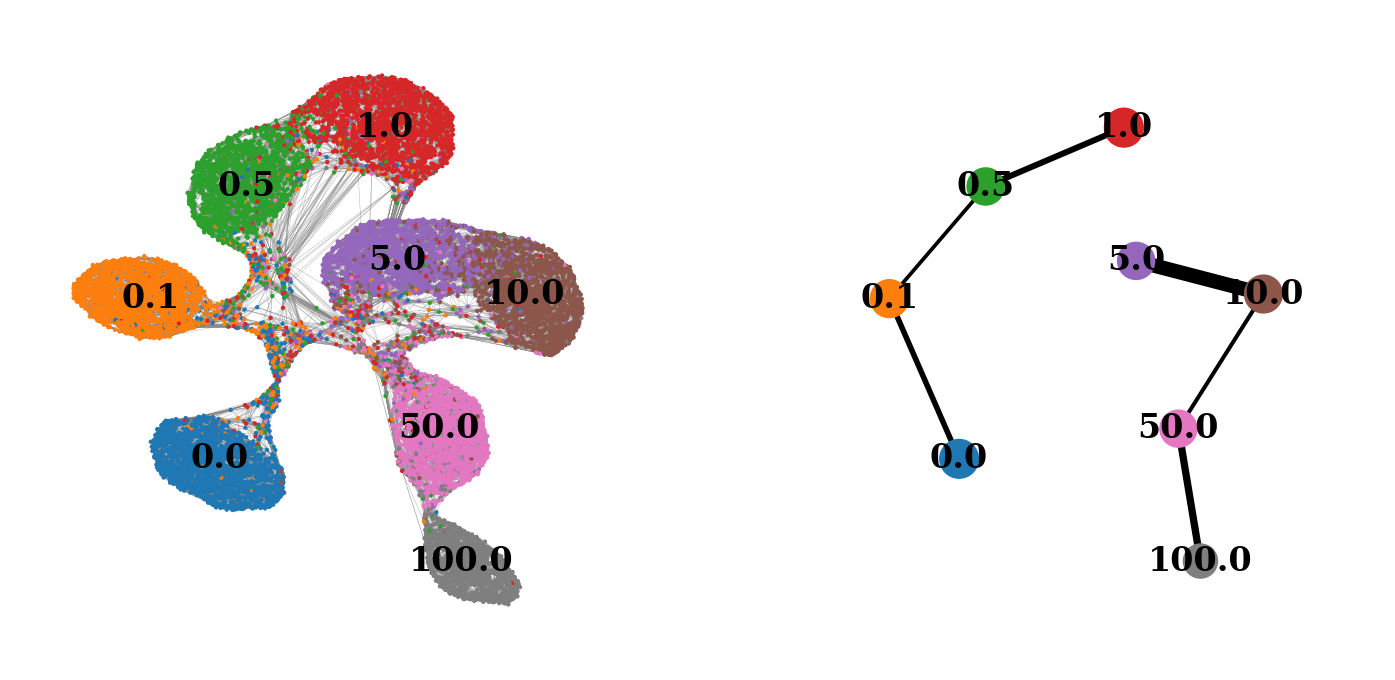

In [408]:
sc.pl.paga_compare(
    latent,
    threshold=0.23,
    title="",
    right_margin=0.2,
    size=10,
    edge_width_scale=0.5,
    legend_fontsize=12,
    fontsize=12,
    frameon=False,
    edges=True,
)

In [409]:
latent.uns["paga"]["connectivities"].A

array([[0.          , 0.3542081866, 0.1599759103, 0.1573726161,
        0.0626632509, 0.054402202 , 0.0537556563, 0.0476973265],
       [0.3542081866, 0.          , 0.2396207878, 0.1672263343,
        0.0837801617, 0.0632599873, 0.0932661596, 0.063117577 ],
       [0.1599759103, 0.2396207878, 0.          , 0.3861157689,
        0.1342240676, 0.0925040764, 0.1144229246, 0.1178254165],
       [0.1573726161, 0.1672263343, 0.3861157689, 0.          ,
        0.2225368466, 0.1793344319, 0.1353979665, 0.1274391201],
       [0.0626632509, 0.0837801617, 0.1342240676, 0.2225368466,
        0.          , 0.92485581  , 0.2282654058, 0.1356625879],
       [0.054402202 , 0.0632599873, 0.0925040764, 0.1793344319,
        0.92485581  , 0.          , 0.2569052537, 0.162923864 ],
       [0.0537556563, 0.0932661596, 0.1144229246, 0.1353979665,
        0.2282654058, 0.2569052537, 0.          , 0.4660932402],
       [0.0476973265, 0.063117577 , 0.1178254165, 0.1274391201,
        0.1356625879, 0.162923864

In [410]:
_adata = adata.copy()
_adata.obs = latent.obs.copy()
_adata.uns = latent.uns.copy()
_adata.obsm = latent.obsm.copy()
_adata.obsp = latent.obsp.copy()

In [411]:
_adata

AnnData object with n_obs × n_vars = 14811 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_val_log', '_scvi_batch', '_scvi_labels', 'dpt_pseudotime', 'c'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'umap', 'diffmap_evals', 'iroot', 'dose_colors', 'c_colors', 'paga', 'dose_sizes'
    obsm: 'X_umap', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [412]:
sc.pp.log1p(_adata)
sc.pp.normalize_total(_adata)
sc.pp.scale(_adata)

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [413]:
_adata.obs["distance"] = _adata.obs["dpt_pseudotime"]
_adata.obs["clusters"] = _adata.obs["dose"]  # just a cosmetic change


In [414]:
_adata.var.index

Index(['SCYL3', 'C1orf112', 'GCLC', 'STPG1', 'KRIT1', 'RAD52', 'MYH16', 'BAD',
       'KLHL13', 'ICA1',
       ...
       'AL589669.1', 'AL391117.1', 'AC092718.8', 'AC015802.6', 'AC087565.3',
       'AC006511.5', 'AC079781.5', 'AL034417.3', 'AC087269.2', 'AL358472.5'],
      dtype='object', name='index', length=4999)

In [415]:
adata[_adata.obs["dpt_pseudotime"].sort_values().index,:]

View of AnnData object with n_obs × n_vars = 14811 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_val_log', '_scvi_batch', '_scvi_labels'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', '_scvi_disentanglement_target'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [416]:
arr = _adata.X

In [417]:
from scanpy._utils import moving_average

In [418]:
import mellon

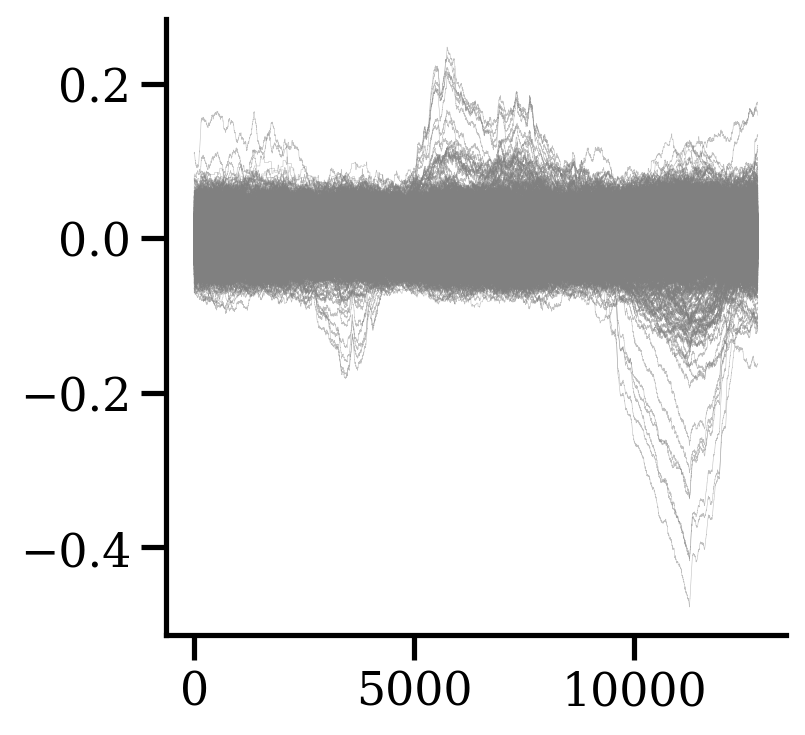

In [419]:
for i in range(4999):
    plt.plot(moving_average(arr[:,i], 2000), linewidth=0.2, color="gray", alpha=0.5)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1228: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1277: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)


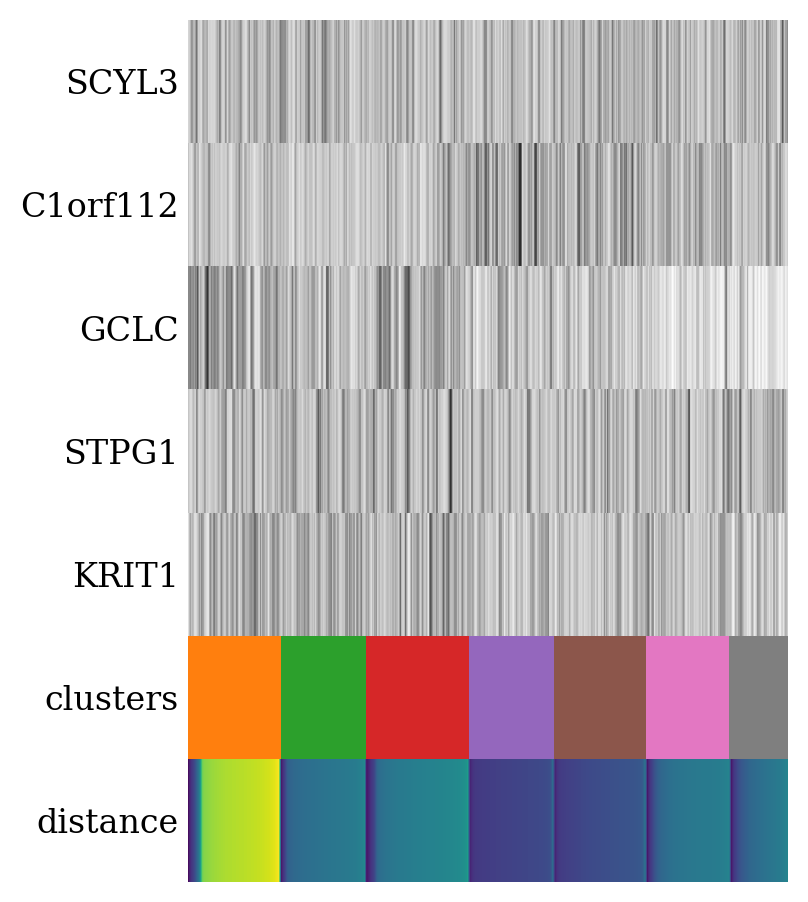

In [420]:
sc.pl.paga_path(
    _adata,
    ['0.1', '0.5', '1.0', '5.0', '10.0', '50.0', '100.0'],
    ['SCYL3', 'C1orf112', 'GCLC', 'STPG1', 'KRIT1'],
    show_node_names=False,
    ytick_fontsize=12,
    left_margin=0.15,
    n_avg=50,
    annotations=["distance"],
    show_yticks=True,
    show_colorbar=False,
    color_map="Greys",
    groups_key="clusters",
    color_maps_annotations={"distance": "viridis"},
    return_data=True,
    show=False,
);

In [421]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from sklearn.cluster import k_means
import palantir
import mellon
import scanpy as sc

import warnings
from numba.core.errors import NumbaDeprecationWarning

In [422]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DisentanglementManager.configurations.get_by_obs_key("dose_val_log").reserved_latent_indices], obs=adata.obs.copy())

In [423]:
sc.tl.pca(latent, n_comps=7)

computing PCA
    with n_comps=7
    finished (0:00:00)


In [424]:
%%time
dm_res = palantir.utils.run_diffusion_maps(latent, pca_key="X_pca", n_components=20)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
CPU times: user 16.2 s, sys: 2.89 s, total: 19.1 s
Wall time: 3.78 s


In [425]:
%%time
model = mellon.DensityEstimator()
log_density = model.fit_predict(latent.obsm["DM_EigenVectors"])

predictor = model.predict

latent.obs["mellon_log_density"] = log_density
latent.obs["mellon_log_density_clipped"] = np.clip(
    log_density, *np.quantile(log_density, [0.05, 1])
)

[2024-04-25 23:26:13,840] [INFO    ] Using sparse Gaussian Process since n_landmarks (5,000) < n_samples (14,811) and rank = 1.0.
[2024-04-25 23:26:13,842] [INFO    ] Computing nearest neighbor distances.
[2024-04-25 23:26:14,763] [INFO    ] Using embedding dimensionality d=20. Use d_method="fractal" to enable effective density normalization.
[2024-04-25 23:26:14,770] [INFO    ] Using covariance function Matern52(ls=0.009924690349754343).
[2024-04-25 23:26:14,771] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2024-04-25 23:26:21,309] [INFO    ] Using rank 5,000 covariance representation.
[2024-04-25 23:26:23,385] [INFO    ] Running inference using L-BFGS-B.
[2024-04-25 23:26:30,015] [INFO    ] Computing predictive function.
CPU times: user 3min 48s, sys: 9.33 s, total: 3min 58s
Wall time: 16.2 s


In [426]:
sc.pp.neighbors(latent, n_neighbors = 15)
sc.tl.umap(latent)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


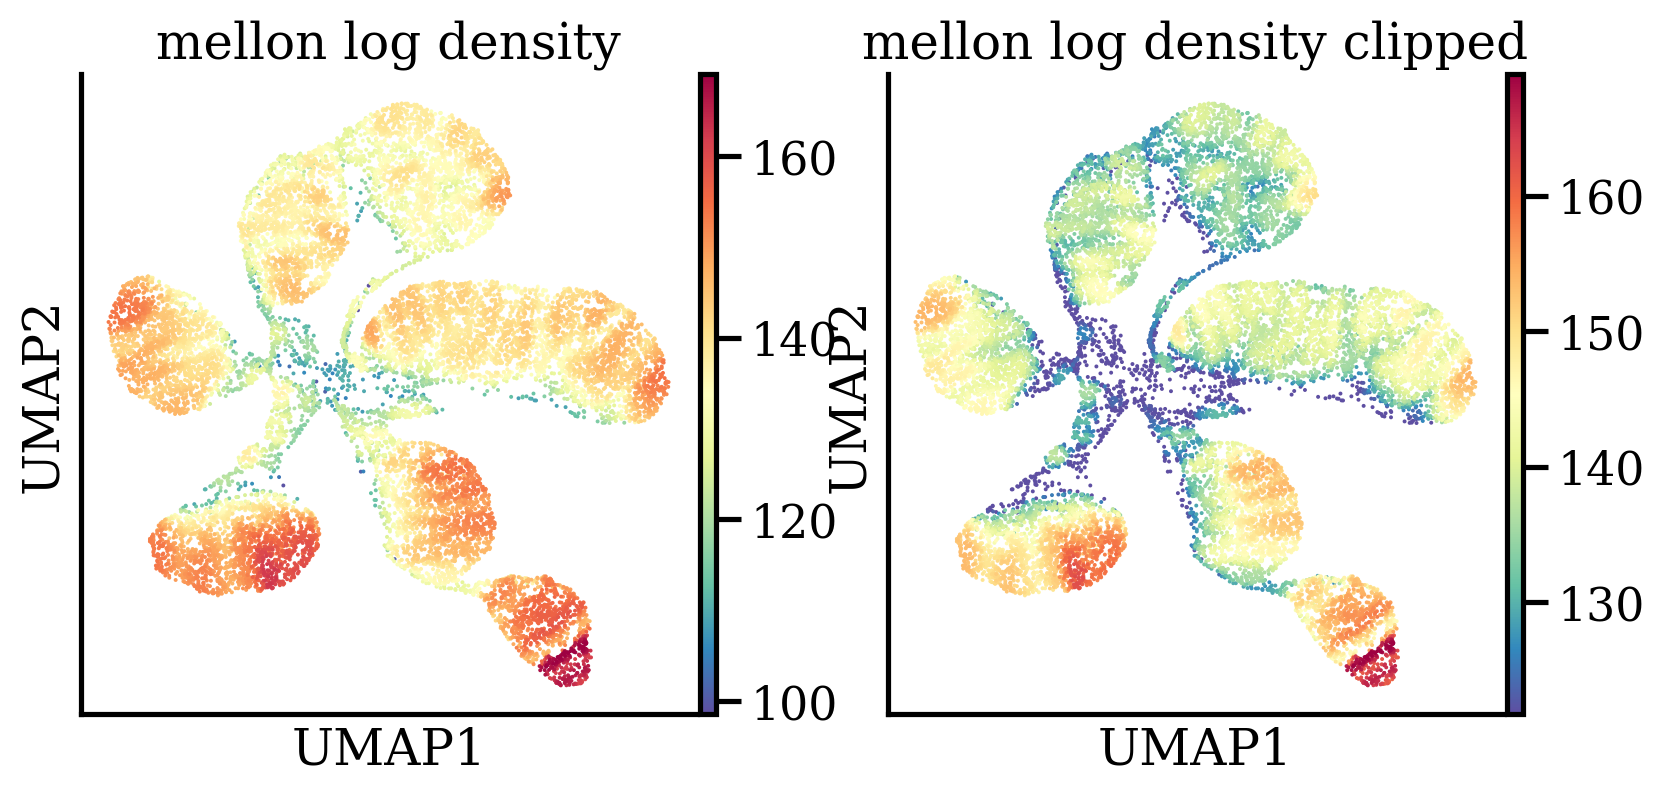

In [427]:
sc.pl.scatter(
    latent, color=["mellon_log_density", "mellon_log_density_clipped"], basis="umap"
)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


<Axes: ylabel='mellon_log_density'>

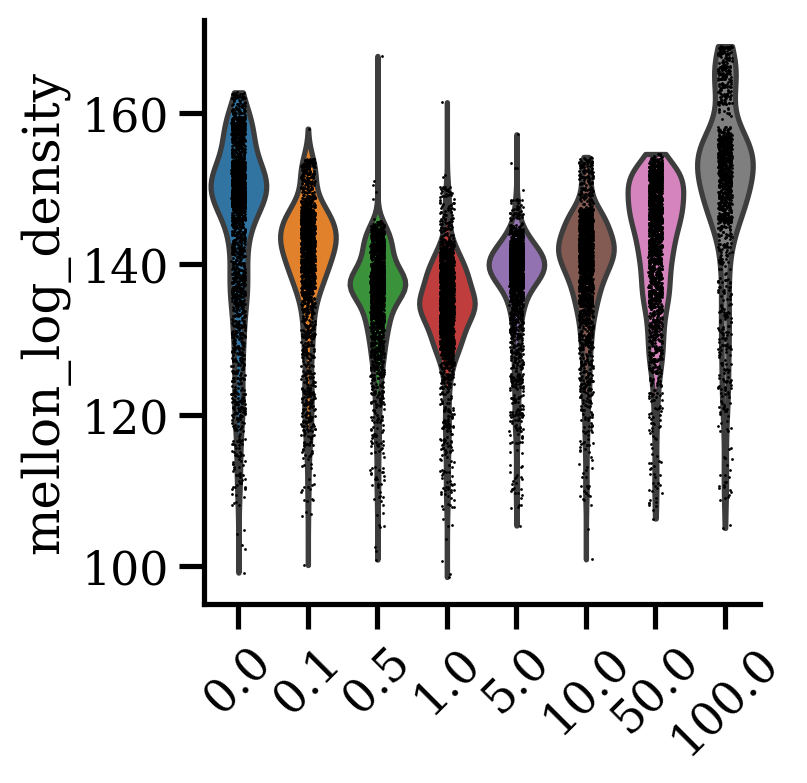

In [428]:
sc.pl.violin(latent, "mellon_log_density", "dose", rotation=45, show=False)

In [429]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DisentanglementManager.configurations.get_by_obs_key("dose_val_log").reserved_latent_indices], obs=adata.obs.copy())
sc.tl.pca(latent, n_comps=7)

computing PCA
    with n_comps=7
    finished (0:00:00)


In [430]:
dm_res = palantir.utils.run_diffusion_maps(latent, n_components=3)
ms_data = palantir.utils.determine_multiscale_space(latent)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [431]:
sc.pp.neighbors(latent)
sc.tl.umap(latent)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


In [432]:
latent

AnnData object with n_obs × n_vars = 14811 × 8
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_val_log', '_scvi_batch', '_scvi_labels'
    uns: 'pca', 'DM_EigenValues', 'neighbors', 'umap'
    obsm: 'X_pca', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'DM_Similarity', 'distances', 'connectivities'

In [433]:
# imputed_X = palantir.utils.run_magic_imputation(latent)

In [434]:
latent

AnnData object with n_obs × n_vars = 14811 × 8
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_val_log', '_scvi_batch', '_scvi_labels'
    uns: 'pca', 'DM_EigenValues', 'neighbors', 'umap'
    obsm: 'X_pca', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled', 'X_umap'
    varm: 'PCs'
    obsp: 'DM_Kernel', 'DM_Similarity', 'distances', 'connectivities'

In [439]:
start_cell = latent.obs.index[np.where([latent.obs["dose_val"] == latent.obs["dose_val"].min()])[1]][0]
end_cell = latent.obs.index[np.where([latent.obs["dose_val"] == latent.obs["dose_val"].max()])[1]][0]


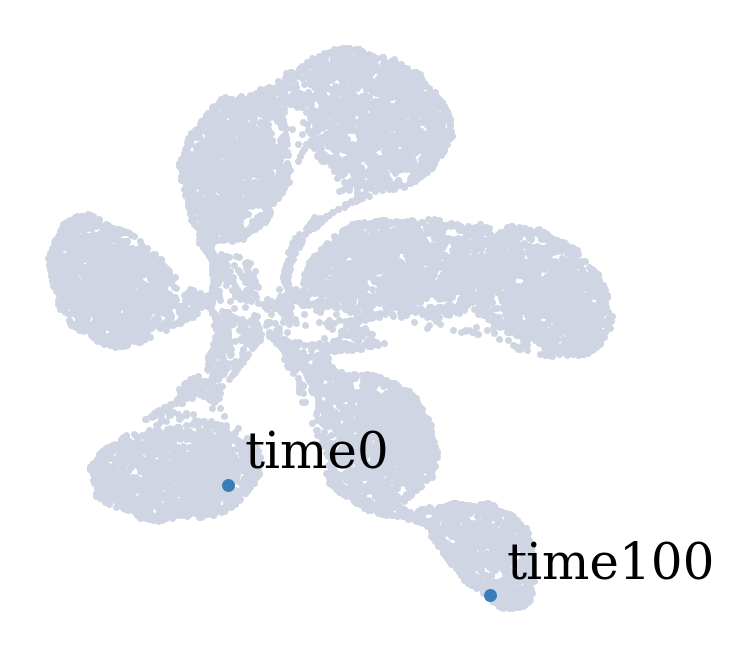

In [440]:
terminal_states = pd.Series(
    ["time0", "time100"],
    index=[start_cell, end_cell],
)

palantir.plot.highlight_cells_on_umap(latent, terminal_states)
plt.show()

(<Figure size 900x300 with 3 Axes>,
 {0: <Axes: title={'center': 'Component 0'}>,
  1: <Axes: title={'center': 'Component 1'}>,
  2: <Axes: title={'center': 'Component 2'}>})

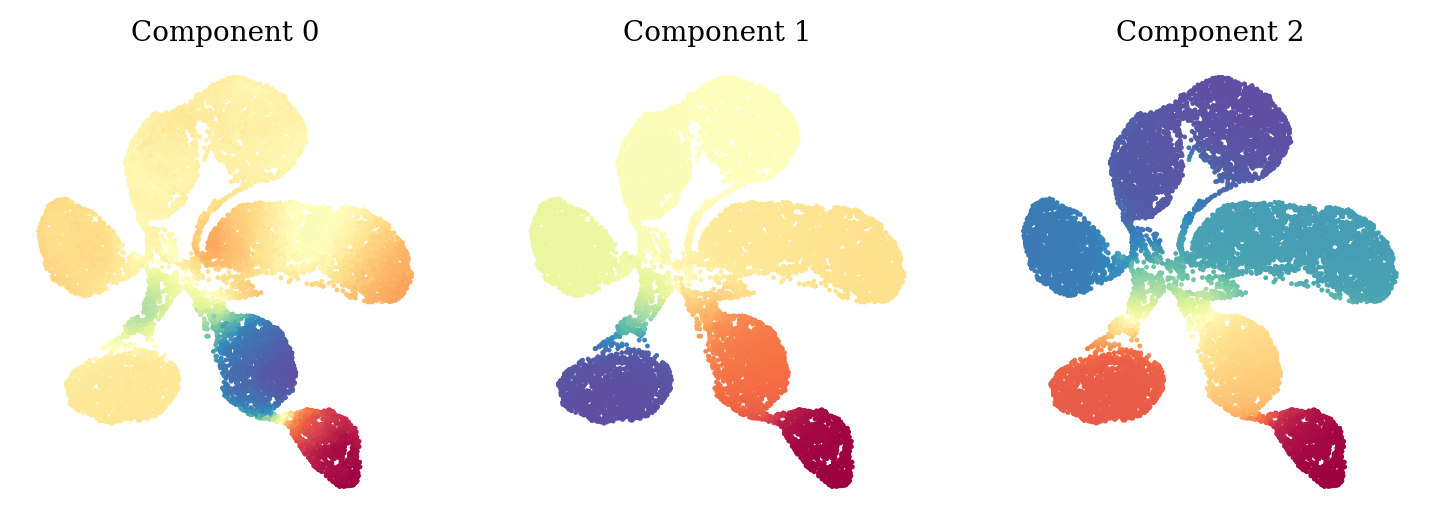

In [441]:
palantir.plot.plot_diffusion_components(latent)

In [442]:
pr_res = palantir.core.run_palantir(
    latent, start_cell, knn=100, terminal_states=terminal_states
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.13030755917231243 minutes
Determining pseudotime...
Shortest path distances using 100-nearest neighbor graph...
Time for shortest paths: 0.8930351853370666 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


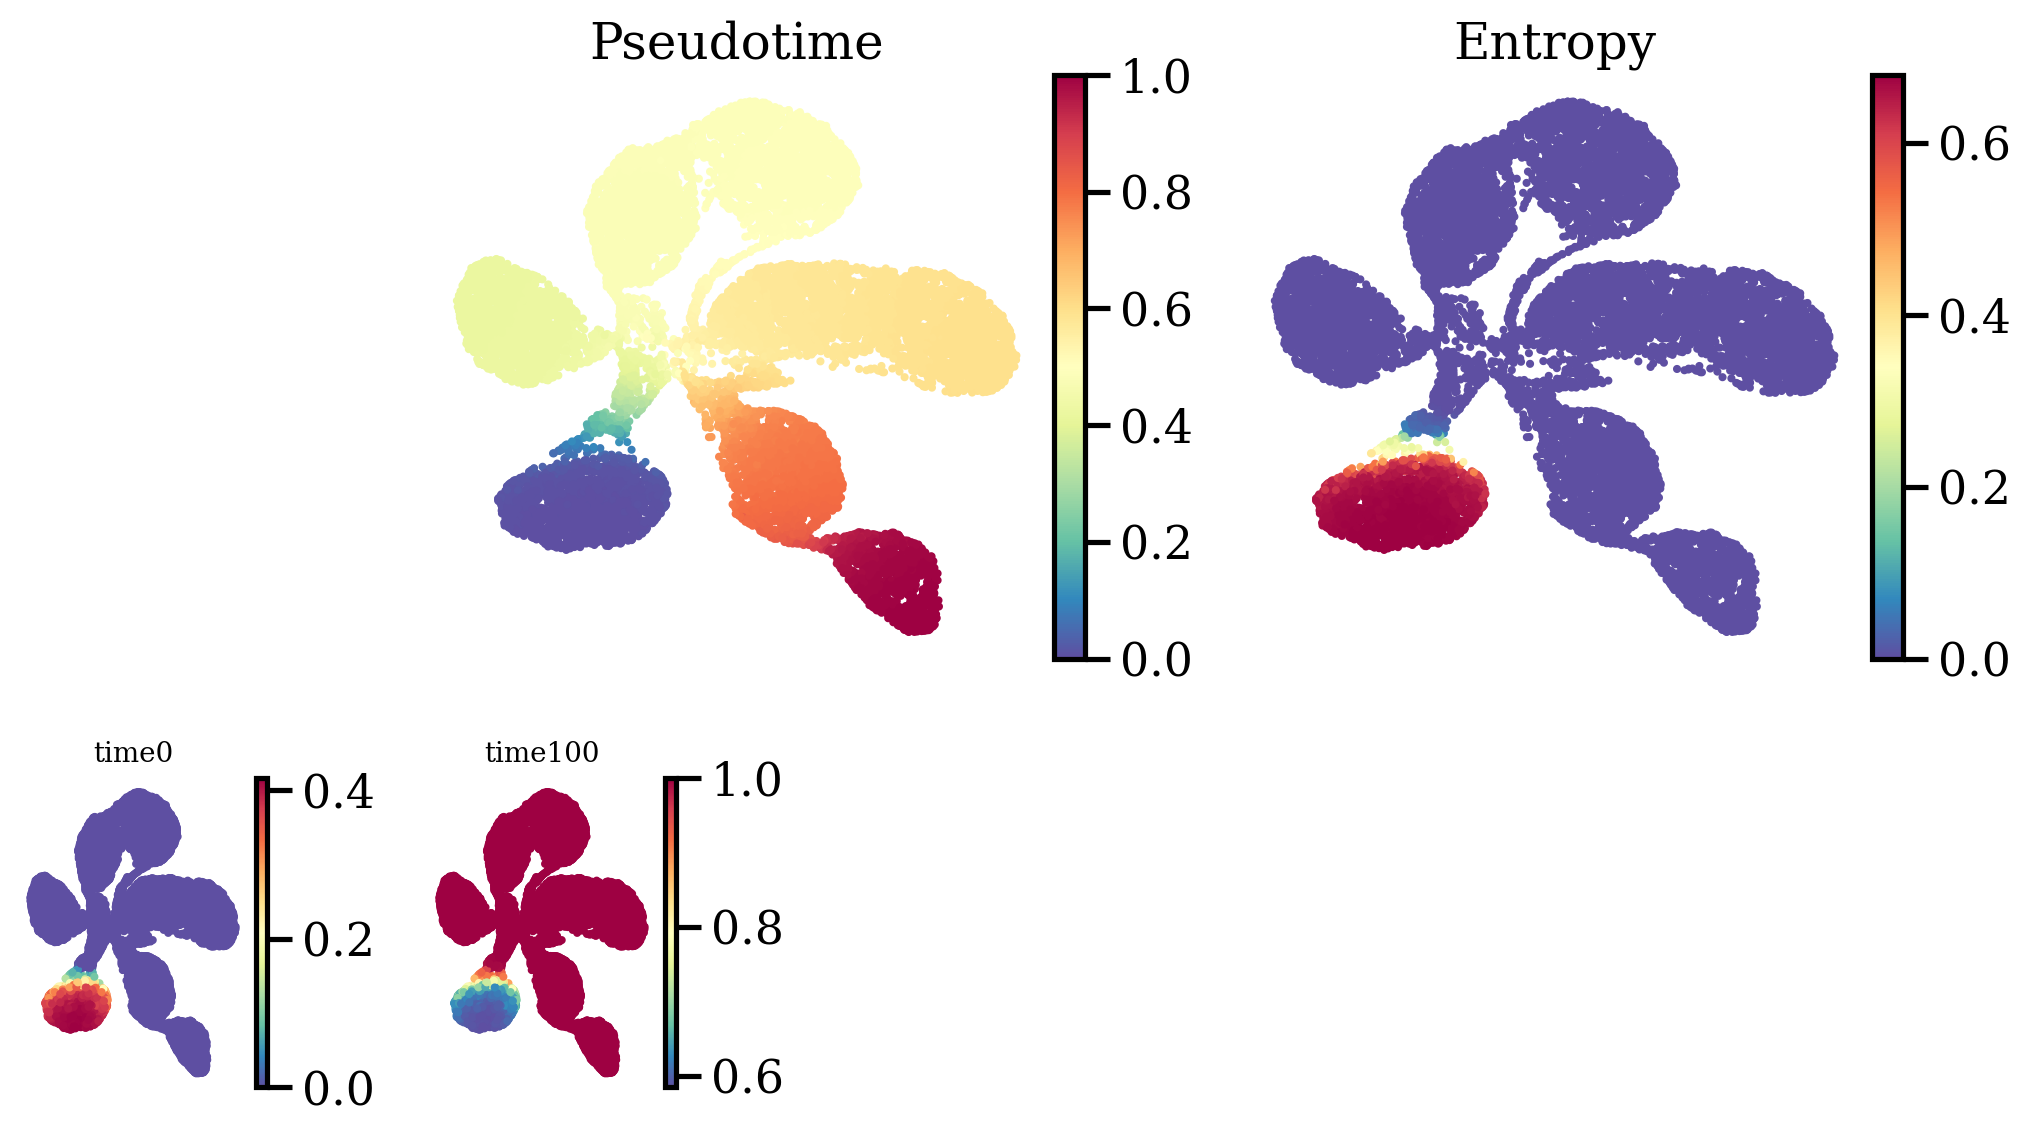

In [443]:
palantir.plot.plot_palantir_results(latent, s=2)
plt.show()

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


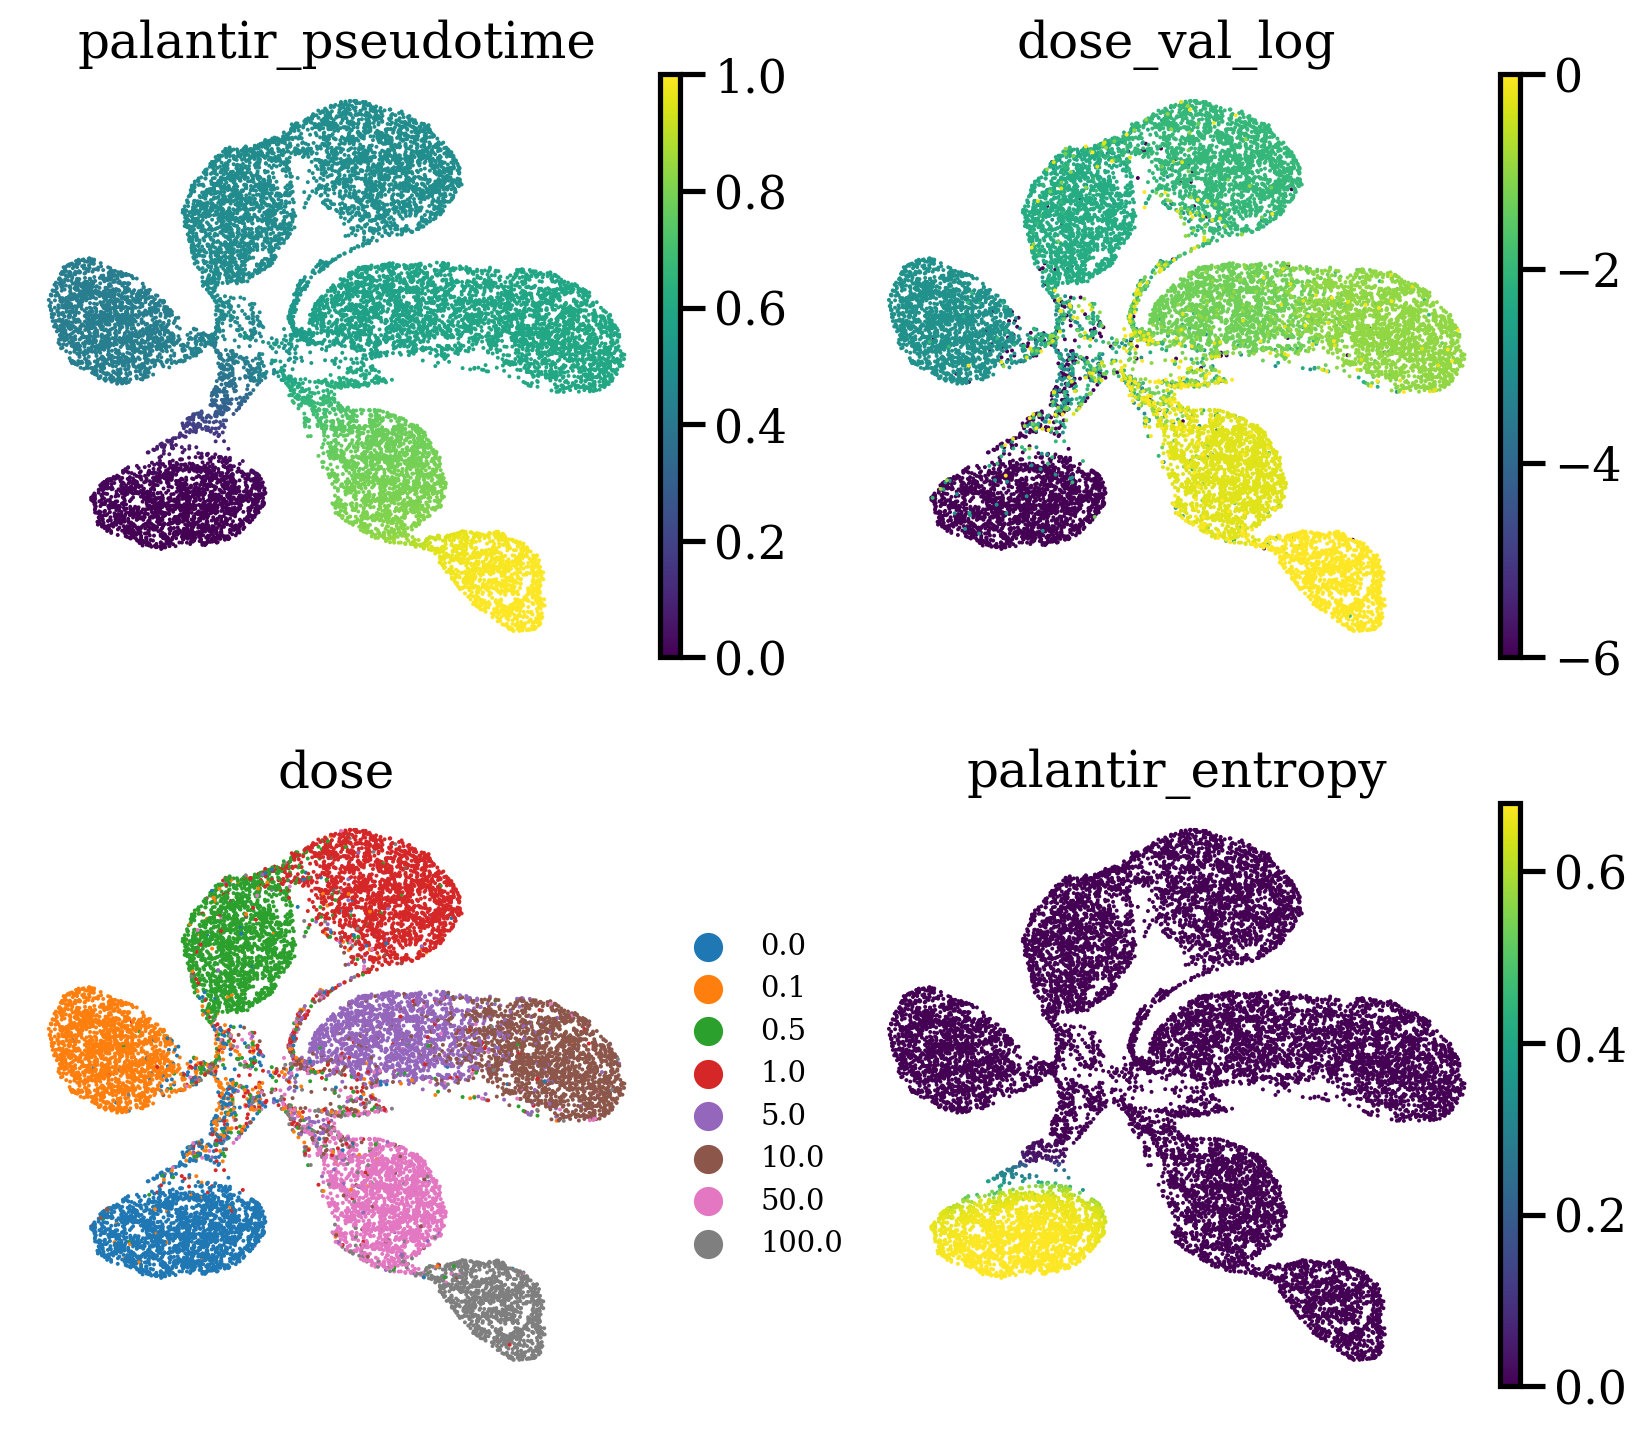

In [444]:
sc.pl.umap(
    latent,
    color=["palantir_pseudotime", "dose_val_log", "dose", "palantir_entropy"],
    ncols=2,
    color_map="viridis",
    frameon=False,
    legend_fontsize="xx-small",
    show=False,
)
plt.show()

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


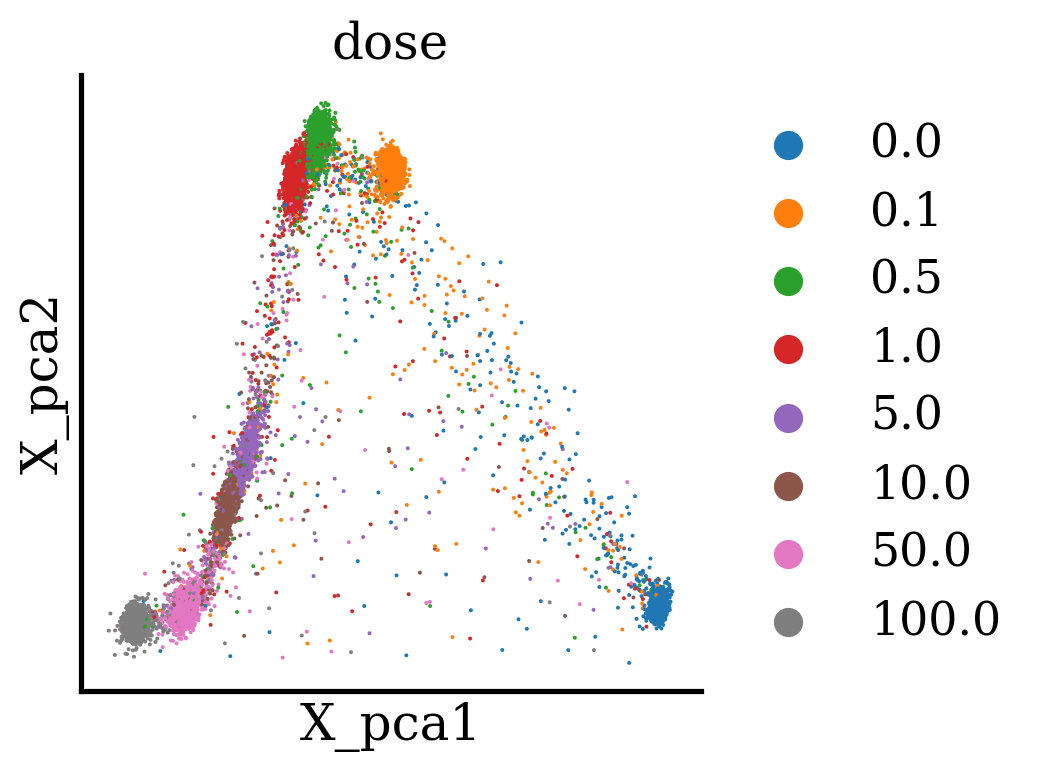

In [445]:
sc.pl.embedding(
    latent,
    basis="X_pca",
    color="dose"
)